In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import glob

import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

%matplotlib inline

import jax
jax.config.update('jax_enable_x64', True)

import jax.random
import jax.numpy as jnp

import discovery as ds
import discovery.models.nanograv as ds_nanograv
import discovery.samplers.numpyro as ds_numpyro

import discovery.likelihood_refactored as dsl

In [2]:
allpsrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob('../data/*-[JB]*.feather'))]
psr = allpsrs[0]

In [3]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement_simple(psr)])
m2 = dsl.PulsarLikelihood([psr.residuals,
                          ds.makenoise_measurement_simple(psr)])

In [4]:
m.logL.params

['B1855+09_efac', 'B1855+09_log10_t2equad']

In [5]:
m2.logL.params

['B1855+09_efac', 'B1855+09_log10_t2equad']

In [6]:
test_pars = ds.sample_uniform(m.logL.params)

In [7]:
%%timeit
jax.block_until_ready(m.logL(test_pars))


237 μs ± 42.7 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
jax.block_until_ready(m2.logL(test_pars))

161 μs ± 16 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
jlogl_m = jax.jit(m.logL)
jlogl_m2 = jax.jit(m2.logL)
jlogl_m(test_pars) == jlogl_m(test_pars)

Array(True, dtype=bool)

In [10]:
%%timeit
jax.block_until_ready(jlogl_m(test_pars))

67.7 μs ± 3.46 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [11]:
%%timeit
jax.block_until_ready(jlogl_m2(test_pars))

64 μs ± 1.32 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [12]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict),
                         ds.makegp_timing(psr, svd=True),
                        #  ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')
                         ])
m2 = dsl.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict),
                         ds.makegp_timing(psr, svd=True),
                        #  ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')
                         ])

In [13]:
test_pars = ds.sample_uniform(m.logL.params)

In [14]:
%%timeit
jax.block_until_ready(m.logL(test_pars))

858 ns ± 6.46 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [15]:
%%timeit
jax.block_until_ready(m2.logL(test_pars))

The slowest run took 4.04 times longer than the fastest. This could mean that an intermediate result is being cached.
1.73 μs ± 977 ns per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
jlogl_m = jax.jit(m.logL)
jlogl_m2 = jax.jit(m2.logL)
jlogl_m(test_pars)==jlogl_m2(test_pars)

Array(False, dtype=bool)

In [17]:
%%timeit
jax.block_until_ready(jlogl_m(test_pars))

6.04 μs ± 28 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [18]:
%%timeit
jax.block_until_ready(jlogl_m2(test_pars))

5.99 μs ± 32 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [19]:
%%prun
for ii in range(10000):
    jax.block_until_ready(m.logL(test_pars))

         50003 function calls in 0.019 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10000    0.007    0.000    0.015    0.000 api.py:2932(block_until_ready)
    10000    0.004    0.000    0.004    0.000 api.py:2943(try_to_block)
        1    0.004    0.004    0.019    0.019 <string>:1(<module>)
    10000    0.003    0.000    0.003    0.000 tree_util.py:87(tree_leaves)
    10000    0.001    0.000    0.001    0.000 {built-in method builtins.isinstance}
    10000    0.001    0.000    0.001    0.000 matrix.py:919(kernelproduct)
        1    0.000    0.000    0.019    0.019 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

In [20]:
%%prun
for ii in range(10000):
    jax.block_until_ready(m2.logL(test_pars))

         70003 function calls in 0.024 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10000    0.010    0.000    0.019    0.000 api.py:2932(block_until_ready)
    10000    0.004    0.000    0.004    0.000 api.py:2943(try_to_block)
        1    0.004    0.004    0.024    0.024 <string>:1(<module>)
    10000    0.003    0.000    0.003    0.000 tree_util.py:87(tree_leaves)
    10000    0.001    0.000    0.001    0.000 matrix_refactored.py:675(kernelproduct)
    10000    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
    10000    0.000    0.000    0.000    0.000 {built-in method builtins.len}
    10000    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
        1    0.000    0.000    0.024    0.024 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

In [101]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict),
                         ds.makegp_timing(psr, svd=True),
                         ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')
                         ])
m2 = dsl.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict),
                         ds.makegp_timing(psr, svd=True),
                         ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')
                         ])

In [102]:
test_pars = ds.sample_uniform(m.logL.params)

In [103]:
%%timeit
jax.block_until_ready(m.logL(test_pars))

259 μs ± 71.1 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [104]:
%%timeit
jax.block_until_ready(m2.logL(test_pars))

373 μs ± 4.85 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [105]:
jlogl_m = jax.jit(m.logL)
jlogl_m2 = jax.jit(m2.logL)
jlogl_m(test_pars)==jlogl_m2(test_pars)

Array(False, dtype=bool)

In [106]:
%%timeit
jax.block_until_ready(jlogl_m(test_pars))

54.4 μs ± 1.45 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [107]:
%%timeit
jax.block_until_ready(jlogl_m2(test_pars))

138 μs ± 1.95 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [108]:
%%prun
for ii in range(10000):
    jax.block_until_ready(m.logL(test_pars))

         2870003 function calls in 3.673 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   100000    0.912    0.000    1.188    0.000 ufunc_api.py:173(__call__)
    20000    0.421    0.000    0.674    0.000 matrix.py:18(<lambda>)
    10000    0.308    0.000    0.308    0.000 api.py:2943(try_to_block)
   130000    0.291    0.000    1.782    0.000 array_methods.py:574(deferring_binary_op)
    20000    0.225    0.000    0.253    0.000 reductions.py:240(sum)
    10000    0.175    0.000    0.175    0.000 linalg.py:167(cho_solve)
    10000    0.168    0.000    3.270    0.000 matrix.py:1330(kernelproduct)
    20000    0.154    0.000    0.156    0.000 lax_numpy.py:7921(diag)
    10000    0.139    0.000    0.271    0.000 ufuncs.py:2598(power)
    10000    0.094    0.000    0.094    0.000 linalg.py:49(cholesky)
   230000    0.091    0.000    0.146    0.000 util.py:132(_arraylike)
   350000    0.072    0.000    0.218    0.000 util.py

In [109]:
%%prun
for ii in range(10000):
    jax.block_until_ready(m2.logL(test_pars))

         2340003 function calls in 3.987 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    90000    1.428    0.000    1.671    0.000 ufunc_api.py:173(__call__)
   130000    0.437    0.000    2.418    0.000 array_methods.py:574(deferring_binary_op)
    20000    0.381    0.000    0.651    0.000 matrix.py:18(<lambda>)
    10000    0.246    0.000    3.759    0.000 <string>:45(kernelproduct)
    20000    0.244    0.000    0.271    0.000 reductions.py:240(sum)
    20000    0.172    0.000    0.174    0.000 lax_numpy.py:7921(diag)
    10000    0.148    0.000    0.280    0.000 ufuncs.py:2598(power)
        1    0.137    0.137    3.987    3.987 <string>:1(<module>)
    10000    0.115    0.000    0.115    0.000 linalg.py:167(cho_solve)
   200000    0.078    0.000    0.124    0.000 util.py:132(_arraylike)
    10000    0.073    0.000    0.073    0.000 linalg.py:49(cholesky)
   300000    0.062    0.000    0.186    0.000 util.py:174(<ge

In [89]:
lls_new = []
lls_old = []
for ii in range(100):
    test_pars = ds.sample_uniform(m.logL.params)
    lls_old.append(m.logL(test_pars))
    lls_new.append(m2.logL(test_pars))

In [90]:
import matplotlib.pyplot as plt

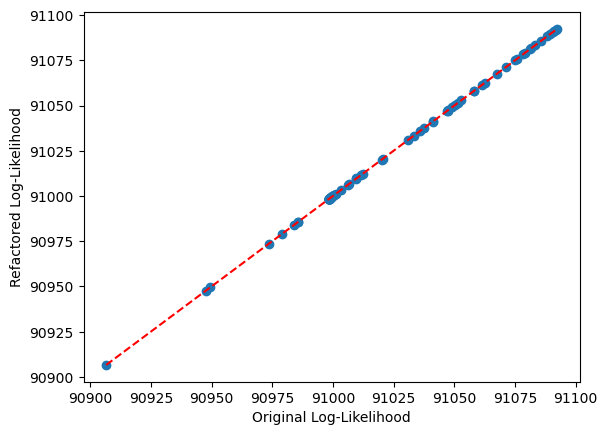

In [91]:
plt.scatter(lls_old, lls_new)
plt.plot([min(lls_old), max(lls_old)], [min(lls_old), max(lls_old)], color='red', linestyle='--')
plt.xlabel('Original Log-Likelihood')
plt.ylabel('Refactored Log-Likelihood')
plt.show()

In [63]:
# Add this to a notebook cell to debug the varP case
import jax

# Create both kernels
m_orig = ds.PulsarLikelihood([psr.residuals, ds.makenoise_measurement_simple(psr)])
m_refact = dsl.PulsarLikelihood([psr.residuals, ds.makenoise_measurement_simple(psr)])

# Explore the structure to find the kernel
print("Original m_orig attributes:", dir(m_orig))
print("Refactored m_refact attributes:", dir(m_refact))

# Try to find the kernel in the likelihood components
print("\nOriginal likelihood components:", m_orig.components)
print("Refactored likelihood components:", m_refact.components)

# Look at the first component that might be the kernel
if hasattr(m_orig.components[0], 'kernel'):
    print("Original kernel type:", type(m_orig.components[0].kernel))
    print("Refactored kernel type:", type(m_refact.components[0].kernel))
else:
    # The kernel might be the component itself
    print("Original component type:", type(m_orig.components[0]))
    print("Refactored component type:", type(m_refact.components[0]))

# Test parameters
test_pars = ds.sample_uniform(m_orig.logL.params)
print("Test parameters:", test_pars)

Original m_orig attributes: ['N', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'clogL', 'conditional', 'delay', 'logL', 'sample', 'sample_conditional', 'y']
Refactored m_refact attributes: ['N', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'clogL', 'conditional', 'delay', 'logL', 'sample', 'sample_conditional', 'y']


AttributeError: 'PulsarLikelihood' object has no attribute 'components'